## Hey There!
Modeling Approach: 1D Convolutional Neural Network  

# Set up

In [ ]:
# @title Imports 
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.metrics import AUC
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import os
import json



import matplotlib.pyplot as plt
from IPython.display import clear_output 
# %config InlineBackend.figure_formats = ['svg']
# from matplotlib.pyplot import figure
# plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

Connect to TPU

In [ ]:
## Connect to TPU ##

# TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)
print("c device: ", c.device)
print(c)
strategy = tf.distribute.TPUStrategy(resolver)

# Clear ouput 
clear_output()

In [ ]:
# Connect to Drive 
from google.colab import drive
drive.mount('/content/drive')
clear_output()

#Data Preprocessing / Normalization 

Get and Preprocess X

In [ ]:
#Load data
Wide_X = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/wideX_Smoothed.pkl')

#Wide_X.fillna(0)
Wide_X = Wide_X.where(Wide_X > 0.0000001, 0)

In [ ]:
Wide_X

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Seperate SEQN from dataframe
SEQN = Wide_X.pop("SEQN")
data_wide = Wide_X

# Normalize from 0.01 to 1
scaler = MinMaxScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

# Set 3-D shape
data_wide = data_wide.reshape(len(data_wide),len(data_wide[0]),1)
data_wide = data_wide.astype(np.float32)
# Set shape for model
data_wide_shape = (data_wide.shape[1],data_wide.shape[2])



print("Shape:", data_wide.shape)

Shape: (5429, 10080, 1)


Preprocess y

In [ ]:
# Load Data Y ----
Y = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/y.pkl')

#Make y array as well 
y = np.hstack(np.asarray(Y)).reshape(len(Y),1)
print(y.shape)
y = y.astype(np.float32)

(5429, 1)


### Stratified Train Test Split

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(data_wide, y, SEQN, test_size=0.2, stratify = y, random_state = 41)

# Train Validation Split
X_trainB, X_valB, y_trainB, y_valB, ids_trainB, ids_valB = train_test_split(X_train, y_train, ids_train, test_size=0.2, stratify = y_train, random_state = 32)

In [ ]:
# Dimentions
n_steps, n_length, n_width = 7, 24, 60  
n_features = 1 

# Reshape Train and Test 
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_width, n_features))
X_trainB = X_trainB.reshape((X_trainB.shape[0], n_steps, n_length, n_width, n_features))
X_valB = X_valB.reshape((X_valB.shape[0], n_steps, n_length, n_width, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_width, n_features))

Visualization of Data

day: 1


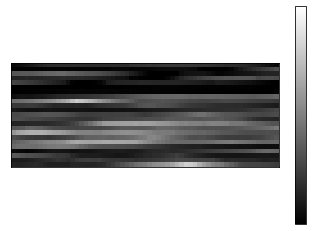

day: 2


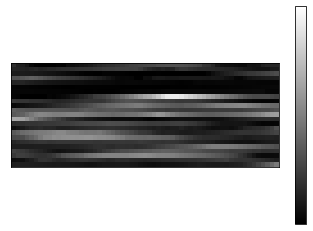

day: 3


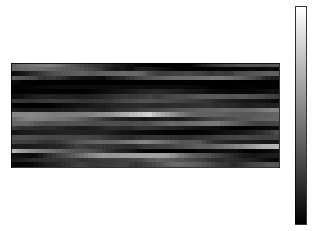

day: 4


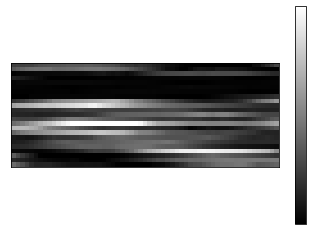

day: 5


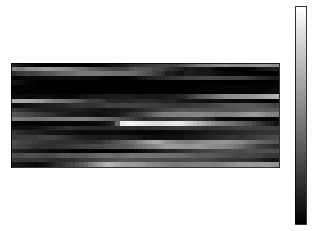

day: 6


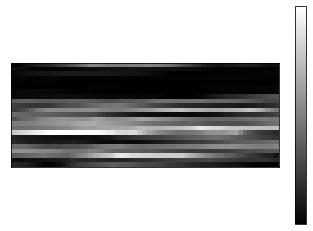

day: 7


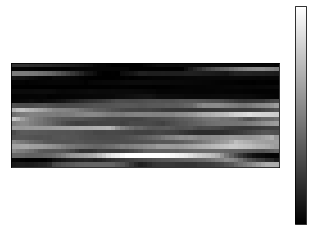

In [ ]:
for day in range(0,7):
  sli = X_train[1, day, 0:23, 0:59, 0]
  print("day:", day + 1)
  plt.imshow(sli, interpolation='none', cmap='gray', vmin=0, vmax=.39)
  plt.colorbar(orientation='vertical',  ticks=[])
  #plt.title("Activity on Day " + str(day+1))
  #plt.xlabel("Minute")
  #plt.ylabel("Hour")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  

#plt.style.use('ggplot')

# Modeling!

In [ ]:
# Import Layers
from keras.layers import ConvLSTM2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling3D

Make Model

In [ ]:
# Model Structure
def create_model():
  model = Sequential()
  
  # Conv Layers 
  model.add(ConvLSTM2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(n_steps, n_length, n_width, n_features) ,return_sequences=True) )
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(ConvLSTM2D(filters=64, kernel_size=(2, 2), padding='valid', return_sequences= False))

  # Feed Forward Layers 
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

Compile Model 

In [ ]:
from keras import optimizers

# Compile Model 
with strategy.scope():
  model = create_model()
  model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
  optimizer= tf.keras.optimizers.Adam(),
  metrics= tf.keras.metrics.AUC(name="auc")
)

In [ ]:
# Save Model 
model.save_weights("reset_weights.h5")

def reset_model():
  model.load_weights("reset_weights.h5")

## Model Visuals

In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 7, 20, 56, 32)     105728    
                                                                 
 activation (Activation)     (None, 7, 20, 56, 32)     0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 10, 28, 32)    0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 9, 27, 64)         98560     
                                                                 
 dropout (Dropout)           (None, 9, 27, 64)         0         
                                                                 
 flatten (Flatten)           (None, 15552)             0         
                                                        

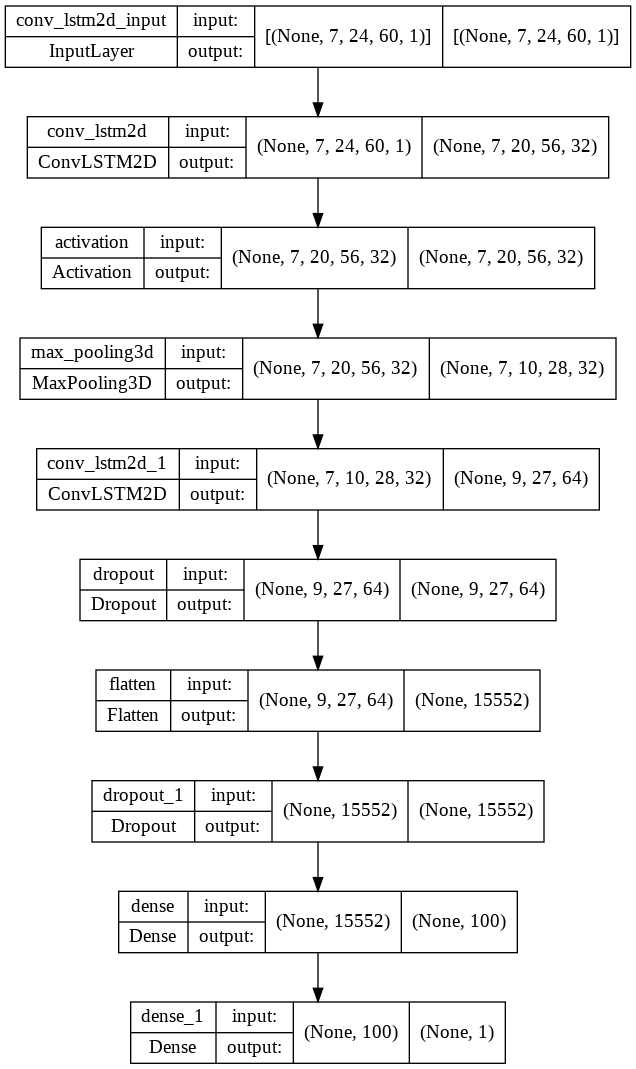

In [ ]:
# Plot Model Architecture 
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##Train Model 

In [ ]:
## Parameters##

# Save Best Weights 
filepath = "VAL-AUC-impr(fr).h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 1,
    monitor='val_auc',
    mode='max',
    save_best_only=True)


# Balance Weights 
n_sd = sum(y)
n_no_sd = len(y) - n_sd
class_weights = {0: (n_no_sd/len(y)),                # Custom Setting Class Weights 
                1: (n_sd/len(y))}

In [ ]:
# Fit model                                              
tf.keras.backend.clear_session()
history = model.fit(
    X_trainB, y_trainB,
    validation_data=(X_valB, y_valB),
    epochs=65, 
    batch_size= 64, # Change size 
    shuffle=False,
    verbose = 1,
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0819 - auc: 0.5368
Epoch 1: val_auc improved from -inf to 0.58074, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 32s 347ms/step - loss: 0.0819 - auc: 0.5368 - val_loss: 0.4117 - val_auc: 0.5807
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0478 - auc: 0.5640
Epoch 2: val_auc did not improve from 0.58074
55/55 [==============================] - 6s 114ms/step - loss: 0.0478 - auc: 0.5640 - val_loss: 0.4081 - val_auc: 0.5692
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.5512
Epoch 3: val_auc improved from 0.58074 to 0.60477, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 6s 118ms/step - loss: 0.0477 - auc: 0.5512 - val_loss: 0.3983 - val_auc: 0.6048
Epoch 4/65
55/55 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.5442
Epoch 4: val_auc did not improve from 0.60477
55/55 [==========

## Graphing

Evaulate 

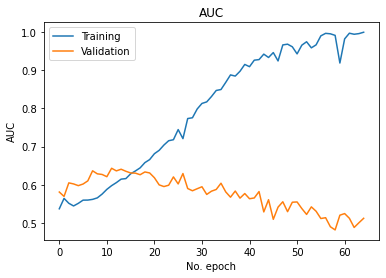

<Figure size 432x288 with 0 Axes>

In [ ]:
history_df = pd.DataFrame({'auc':history.history['auc'], 'val_auc':history.history['val_auc']})
history_df.to_csv("history_df.csv", index = False)

# Plot history: AUC
plt.plot(history_df['auc'], label='Training')
plt.plot(history_df['val_auc'], label='Validation')
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.savefig('')

In [ ]:
# Evaluate 
model.evaluate(X_test, y_test, batch_size = 64)
#Keras Test AUC
from keras.models import load_model
test_set_model = keras.models.load_model('VAL-AUC-impr(fr).h5')
results = test_set_model.evaluate(X_test, y_test, batch_size = 64)
print("--------------------------")
print(f'Keras Model Loading Test AUC: {round(results[1],2)}')
print("--------------------------")


#SKLearn Test AUC 
preds = test_set_model.predict(X_test)
from sklearn.metrics import r2_score, roc_auc_score
print(f'SKLearn Test AUC: {round(roc_auc_score(y_test, preds),3)}')
print("--------------------------")
#plt.plot(preds)
#plt.title('Predictions for Test Set')
#plt.show()
#plt.scatter(y_test, preds)

17/17 [==============================] - 3s 126ms/step - loss: 0.3793 - auc: 0.6536
--------------------------
Keras Model Loading Test AUC: 0.65
--------------------------
SKLearn Test AUC: 0.663
--------------------------


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.663


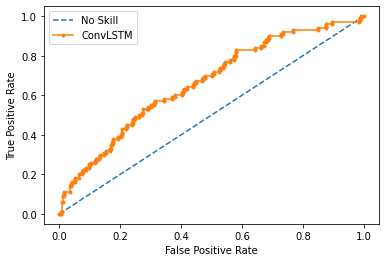

In [ ]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc(filepath, X_test, y_test):
  test_set_model = keras.models.load_model(filepath)
  # NO skill
  ns_probs = [0 for _ in range(len(y_test))]
  # predict probabilities
  lr_probs = test_set_model.predict(X_test)
  # keep probabilities for the positive outcome only
  #lr_probs = lr_probs[:, 1]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Logistic: ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

  # plot the roc curve for the model
  figure(figsize=(8, 8), dpi=80)
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ConvLSTM')
  # axis labels
  pyplot.xlabel('False Positive Rate', fontsize=14)
  pyplot.ylabel('True Positive Rate', fontsize=14)
  pyplot.title('ROC Curve: ConvLSTM Model', fontsize=16)
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

plot_roc('VAL-AUC-impr(fr).h5', X_test, y_test)

#K-Fold Cross Validation

Resetting model..
Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0776 - auc: 0.5188
Epoch 1: val_auc improved from -inf to 0.59038, saving model to VAL-AUC-impr(fr)1.h5
55/55 [==============================] - 7s 125ms/step - loss: 0.0776 - auc: 0.5188 - val_loss: 0.4392 - val_auc: 0.5904
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0476 - auc: 0.5590
Epoch 2: val_auc did not improve from 0.59038
55/55 [==============================] - 6s 117ms/step - loss: 0.0476 - auc: 0.5590 - val_loss: 0.4382 - val_auc: 0.5902
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0475 - auc: 0.5658
Epoch 3: val_auc improved from 0.59038 to 0.60348, saving model to VAL-AUC-impr(fr)1.h5
55/55 [==============================] - 7s 123ms/step - loss: 0.0475 - auc: 0.5658 - val_loss: 0.4374 - val_auc: 0.6035
Epoch 4/65
55/55 [==============================] - ETA: 0s - loss: 0.0474 - auc: 0.5610
Epoch 4: val_auc did not improve from 0.6034

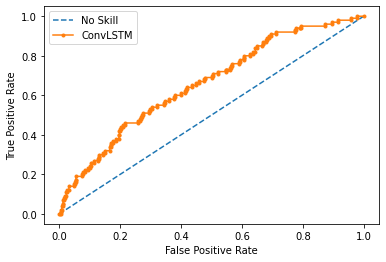

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 2s 122ms/step - loss: 0.4311 - auc: 0.6302
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


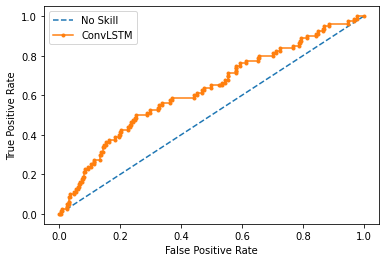

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 1
Resetting model..
Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0773 - auc: 0.5104
Epoch 1: val_auc improved from -inf to 0.57329, saving model to VAL-AUC-impr(fr)2.h5
55/55 [==============================] - 7s 130ms/step - loss: 0.0773 - auc: 0.5104 - val_loss: 0.4429 - val_auc: 0.5733
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.5248
Epoch 2: val_auc improved from 0.57329 to 0.58049, saving model to VAL-AUC-impr(fr)2.h5
55/55 [==============================] - 7s 122ms/step - loss: 0.0477 - auc: 0.5248 - val_loss: 0.4463 - val_auc: 0.5805
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0475 - auc: 0.5416
Epoch 3: val_auc did not improve from 0.58049
55/55 [==============================] - 6s 117ms/step - loss: 0.0475 - auc: 0.5416 - val_loss: 0.4443 - val_auc: 0.5695
Epoch 4/65
55/55 [==============================] - ETA: 0s - loss: 0.0475 -

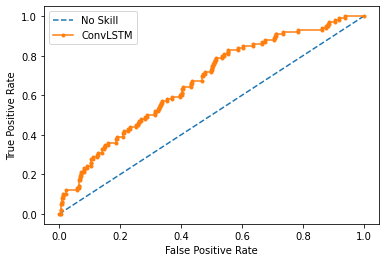

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 2s 120ms/step - loss: 0.4477 - auc: 0.6695
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.663


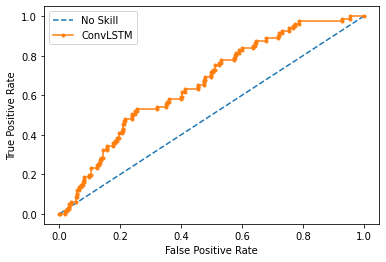

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 2
Resetting model..
Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0754 - auc: 0.5115
Epoch 1: val_auc improved from -inf to 0.55152, saving model to VAL-AUC-impr(fr)3.h5
55/55 [==============================] - 7s 125ms/step - loss: 0.0754 - auc: 0.5115 - val_loss: 0.4149 - val_auc: 0.5515
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0476 - auc: 0.5632
Epoch 2: val_auc improved from 0.55152 to 0.57039, saving model to VAL-AUC-impr(fr)3.h5
55/55 [==============================] - 7s 120ms/step - loss: 0.0476 - auc: 0.5632 - val_loss: 0.4121 - val_auc: 0.5704
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0474 - auc: 0.5713
Epoch 3: val_auc improved from 0.57039 to 0.58118, saving model to VAL-AUC-impr(fr)3.h5
55/55 [==============================] - 7s 120ms/step - loss: 0.0474 - auc: 0.5713 - val_loss: 0.4113 - val_auc: 0.5812
Epoch 4/65
55/55 [================

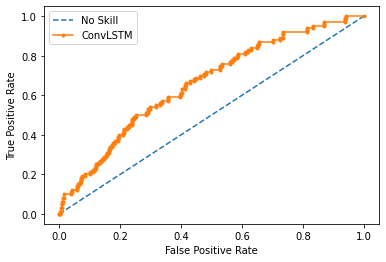

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 2s 123ms/step - loss: 0.4040 - auc: 0.6315
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.628


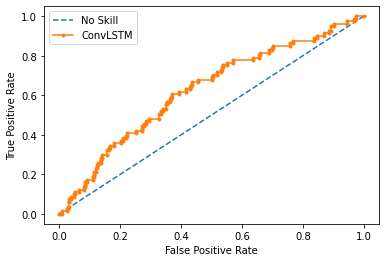

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 3
Resetting model..
Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0757 - auc: 0.5183
Epoch 1: val_auc improved from -inf to 0.52213, saving model to VAL-AUC-impr(fr)4.h5
55/55 [==============================] - 7s 126ms/step - loss: 0.0757 - auc: 0.5183 - val_loss: 0.4388 - val_auc: 0.5221
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0478 - auc: 0.5415
Epoch 2: val_auc improved from 0.52213 to 0.53931, saving model to VAL-AUC-impr(fr)4.h5
55/55 [==============================] - 7s 121ms/step - loss: 0.0478 - auc: 0.5415 - val_loss: 0.4434 - val_auc: 0.5393
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0476 - auc: 0.5504
Epoch 3: val_auc improved from 0.53931 to 0.54411, saving model to VAL-AUC-impr(fr)4.h5
55/55 [==============================] - 7s 120ms/step - loss: 0.0476 - auc: 0.5504 - val_loss: 0.4414 - val_auc: 0.5441
Epoch 4/65
55/55 [================

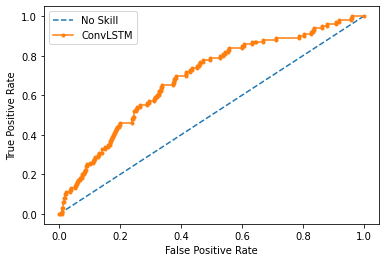

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 2s 121ms/step - loss: 0.4271 - auc: 0.6400
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.631


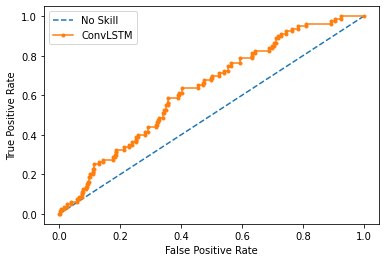

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 4
Resetting model..
Epoch 1/65
55/55 [==============================] - ETA: 0s - loss: 0.0757 - auc: 0.5154
Epoch 1: val_auc improved from -inf to 0.58737, saving model to VAL-AUC-impr(fr)5.h5
55/55 [==============================] - 7s 127ms/step - loss: 0.0757 - auc: 0.5154 - val_loss: 0.4736 - val_auc: 0.5874
Epoch 2/65
55/55 [==============================] - ETA: 0s - loss: 0.0481 - auc: 0.5270
Epoch 2: val_auc did not improve from 0.58737
55/55 [==============================] - 6s 118ms/step - loss: 0.0481 - auc: 0.5270 - val_loss: 0.4505 - val_auc: 0.5173
Epoch 3/65
55/55 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.5410
Epoch 3: val_auc did not improve from 0.58737
55/55 [==============================] - 6s 117ms/step - loss: 0.0477 - auc: 0.5410 - val_loss: 0.4490 - val_auc: 0.5382
Epoch 4/65
55/55 [==============================] - ETA: 0s - loss: 0.0476 - auc: 0.5521
Epoch 4: val_auc did not impr

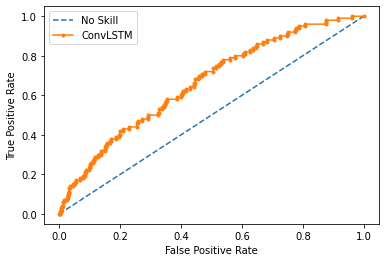

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 2s 124ms/step - loss: 0.4472 - auc: 0.6454
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.650


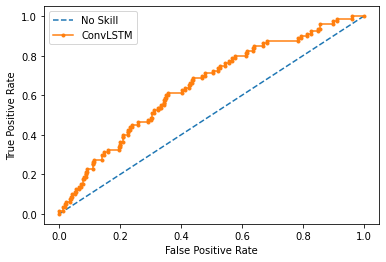

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 5

CV Test AUC----------------------------
Individual scores: [0.6617647409439087, 0.6507555246353149, 0.6550811529159546, 0.6752890348434448, 0.6520588397979736]
Mean: 0.6589898586273193
std: 0.008994269017968166

CV Val AUC-----------------------------
Individual scores: [0.6301964521408081, 0.6695494651794434, 0.6314783096313477, 0.6399666666984558, 0.6453759670257568]
Mean: 0.6433133721351624
std: 0.014254189614274455
CPU times: user 7min 40s, sys: 1min 10s, total: 8min 51s
Wall time: 36min 55s


In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

# Global Score List Buckets
cv_test_scores=[]
cv_val_scores=[]

# K fold parameters 
seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# run K-fold 
count = 1
for train, val in kfold.split(X_train, y_train):
  
  # Create New Training Set 
  X_training = X_train[train]
  y_training = y_train[train]
  # Create new Validation Sets 
  X_val = X_train[val]
  y_val = y_train[val]

  # Reset model 
  print("Resetting model..")
  reset_model()
  # Checkpoints
  filepath = "VAL-AUC-impr(fr)" + str(count) +".h5"

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 2,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

  # fit model   
  tf.keras.backend.clear_session()
  history = model.fit(
      X_training, y_training,
      validation_data=(X_val, y_val),
      epochs=65, # Make Epochs larger
      batch_size= 64, # Change size 
      shuffle=False,
      verbose = 1,
      class_weight=class_weights,
      callbacks=[model_checkpoint_callback]
  )


 
  # Eval model 
  # model_eval()
  from keras.models import load_model
  test_set_model = keras.models.load_model(filepath)
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\ntest set:")
  scores = test_set_model.evaluate(X_test, y_test, batch_size=64) # Test Set
  cv_test_scores.append(scores[1])
  plot_roc(filepath, X_test, y_test)
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\nval set:")
  scores = test_set_model.evaluate(X_val, y_val, batch_size=64)  # Validation Set
  cv_val_scores.append(scores[1])
  plot_roc(filepath, X_val, y_val)



  # Save model 
  print("Saving model...")
  #save_model(count)
  # Save files
  print("Saving files...")
  #save_files(count)

  # increment 
  print("FINISHED CYCLE NUMBER:", count)
  count += 1 

# Score Eval
print("\nCV Test AUC----------------------------")
print("Individual scores:", cv_test_scores)
print("Mean:", np.mean(cv_test_scores))
print("std:", np.std(cv_test_scores))
print("\nCV Val AUC-----------------------------")
print("Individual scores:", cv_val_scores)
print("Mean:", np.mean(cv_val_scores))
print("std:", np.std(cv_val_scores))